In [71]:
import time
start_time = time.time()

In [72]:
import math
import numpy as np
CONSTANTS_RADIUS_OF_EARTH = 6371000.     # meters (m)

In [73]:
from sklearn.neighbors import KernelDensity

In [74]:
import pandas as pd
import numpy as np 
import csv
from PIL import Image
import matplotlib.pyplot as plt
#from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema

In [75]:
data_path = "20181024_d8_0830_0900.csv" # define path to dataset
# fps = 25

### read data

In [76]:

def read_uas4t_csv(path):
    metadata_cols = ['track_id', 'type', 'traveled_d', 'avg_speed']
    metadata_dtypes = [int, str, float, float]
    data_cols = ['lat', 'lon', 'speed', 'lat_acc', 'lon_acc', 'time', 'track_id']
    
    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols)-1
    
    metadata_rows = list()
    data_rows = list()
    
    with open(data_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [float(item) for item in row[metadata_colsize:]
                          if len(item) > 0]
            for i in range(0,len(data_traj),data_colsize):
                data_row = data_traj[i:i+data_colsize] + [track_id]
                data_rows.append(data_row)
            
    data = pd.DataFrame(data_rows, columns=data_cols)     
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

In [77]:
metadata, data = read_uas4t_csv(data_path)

In [78]:
data.head()

,lat,lon,speed,lat_acc,lon_acc,time,track_id
0,37.990463,23.733359,0.0,0.0,0.0,0.00,1
1,37.990463,23.733359,0.0,0.0,0.0,0.04,1
2,37.990463,23.733359,0.0,0.0,0.0,0.08,1
3,37.990463,23.733359,0.0,0.0,0.0,0.12,1
4,37.990463,23.733359,0.0,0.0,0.0,0.16,1


In [79]:
metadata.head()

,type,traveled_d,avg_speed
track_id,,,
1,Car,94.35,1.033608
2,Car,14.04,0.051467
3,Car,27.74,0.101729
4,Bus,318.73,1.169887
5,Car,166.38,0.899897


In [80]:
fps = 25
max(abs(round(fps*data['time'])-fps*data['time']))

1.8189894035458565e-12

In [81]:
data['frame'] = round(fps*data['time']).astype(int)
data.set_index(['track_id','frame'],drop=True,inplace=True)

In [52]:
data.head()

lat        lon  speed  lat_acc  lon_acc  time
track_id frame                                                     
1        0      37.990463  23.733359    0.0      0.0      0.0  0.00
         1      37.990463  23.733359    0.0      0.0      0.0  0.04
         2      37.990463  23.733359    0.0      0.0      0.0  0.08
         3      37.990463  23.733359    0.0      0.0      0.0  0.12
         4      37.990463  23.733359    0.0      0.0      0.0  0.16

### Convert GPS to XY coordinates and data processing

In [53]:
def GPStoXY(lat, lon, ref_lat, ref_lon):
        # input GPS and Reference GPS in degrees
        # output XY in meters (m) X:North Y:East
        lat_rad = math.radians(lat)
        lon_rad = math.radians(lon)
        ref_lat_rad = math.radians(ref_lat)
        ref_lon_rad = math.radians(ref_lon)

        sin_lat = math.sin(lat_rad)
        cos_lat = math.cos(lat_rad)
        ref_sin_lat = math.sin(ref_lat_rad)
        ref_cos_lat = math.cos(ref_lat_rad)

        cos_d_lon = math.cos(lon_rad - ref_lon_rad)

        arg = np.clip(ref_sin_lat * sin_lat + ref_cos_lat * cos_lat * cos_d_lon, -1.0, 1.0)
        c = math.acos(arg)

        k = 1.0
        if abs(c) > 0:
            k = (c / math.sin(c))

        x = float(k * (ref_cos_lat * sin_lat - ref_sin_lat * cos_lat * cos_d_lon) * CONSTANTS_RADIUS_OF_EARTH)
        y = float(k * cos_lat * math.sin(lon_rad - ref_lon_rad) * CONSTANTS_RADIUS_OF_EARTH)

        return x, y


In [83]:
ref_lat = data.lat.min()
ref_lon = data.lon.min()

data["x"] = data.apply(lambda x: GPStoXY(x.lat, x.lon, ref_lat, ref_lon)[0], axis=1)
data["y"] = data.apply(lambda x: GPStoXY(x.lat, x.lon, ref_lat, ref_lon)[1], axis=1)


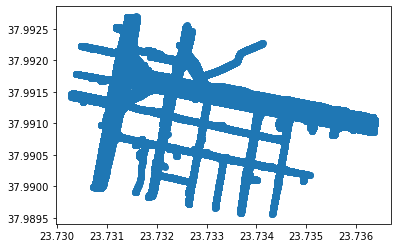

In [88]:
plt.scatter(data.lon,data.lat)
plt.show()

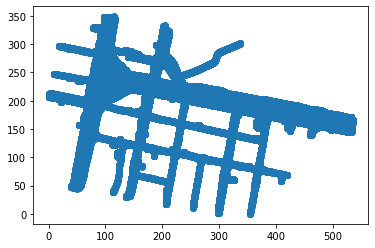

In [87]:
plt.scatter(data.y,data.x)

plt.show()

In [90]:
data["x1"] = data.apply(lambda x: x.x* math.cos(0.2041075902)-x.y*math.sin(0.2041075902), axis=1)
data["y1"] = data.apply(lambda x: x.x* math.sin(0.2041075902)+x.y*math.cos(0.2041075902), axis=1)


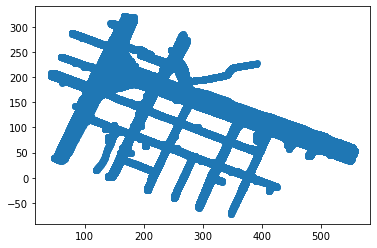

In [91]:
plt.scatter(data.y1,data.x1)

plt.show()

In [97]:
data.head()

lat        lon  speed  lat_acc  lon_acc  time  \
track_id frame                                                        
1        0      37.990463  23.733359    0.0      0.0      0.0  0.00   
         1      37.990463  23.733359    0.0      0.0      0.0  0.04   
         2      37.990463  23.733359    0.0      0.0      0.0  0.08   
         3      37.990463  23.733359    0.0      0.0      0.0  0.12   
         4      37.990463  23.733359    0.0      0.0      0.0  0.16   

                         x           y         x1          y1  
track_id frame                                                 
1        0      100.413493  270.176213  43.566213  284.921113  
         1      100.413493  270.176213  43.566213  284.921113  
         2      100.413493  270.176213  43.566213  284.921113  
         3      100.413493  270.176213  43.566213  284.921113  
         4      100.413493  270.176213  43.566213  284.921113

In [12]:
lat0 = data['lat'].min()
lat1 = data['lat'].max()
dlat = lat1-lat0

lon0 = data['lon'].min()
lon1 = data['lon'].max()
dlon = lon1-lon0

In [13]:
print([lat0, lon0, lat1, lon1])

[37.98956, 23.730276, 37.992702, 23.736387]


In [14]:
a = 6378.137          # equitorial radius from WGS84 model in km
f = 1./298.257223563  # spheroid flattening factor from WGS84 model

e2 = f*(2-f)          # eccentricity squared

sin_lat0 = np.sin(np.deg2rad(lat0))
cos_lat0 = np.cos(np.deg2rad(lat0))
n = np.sqrt(1 - e2*sin_lat0**2)

R1 = (1-e2) * a / n**3
R2 = a / n

dN = R1 * np.deg2rad(dlat)
dE = R2 * cos_lat0 * np.deg2rad(dlon)

In [15]:
true_diag = 658.387
flat_diag = 1e3*np.sqrt(dN**2 + dE**2)
print(round(flat_diag-true_diag,3)) # print error to 3 significant digits

-18.229


In [16]:
def convLL(LLcol,scale,LL0):
    return (scale*(LLcol-LL0)).apply(round).astype(int)

scale = 1e6

In [17]:
data['N'] = convLL(data['lat'],scale=scale,LL0=lat0)
data['E'] = convLL(data['lon'],scale=scale,LL0=lon0)

In [18]:
data.head()

lat        lon  speed  lat_acc  lon_acc  time    N     E
track_id frame                                                                
1        0      37.990463  23.733359    0.0      0.0      0.0  0.00  903  3083
         1      37.990463  23.733359    0.0      0.0      0.0  0.04  903  3083
         2      37.990463  23.733359    0.0      0.0      0.0  0.08  903  3083
         3      37.990463  23.733359    0.0      0.0      0.0  0.12  903  3083
         4      37.990463  23.733359    0.0      0.0      0.0  0.16  903  3083

In [19]:
Nrange = data['N'].max()+1
Erange = data['E'].max()+1

### Create heatmap

In [1]:
def create_traffic_heatmap(pos,sat_count=10,min_count=1):    
    img_array = np.zeros((Nrange,Erange))     # initalize image array
    
    uniques = pos.apply(pd.value_counts)                     # find unique values and apply to array
    img_array[tuple(np.asarray(tuple(uniques.index)).T)] = uniques.values
    img_array[img_array < min_count] = 0
        
    img_array = np.clip(img_array,0,sat_count) / sat_count        # scale and saturate
    
    im = Image.fromarray(np.uint8(np.flipud(img_array)*255),'L')  # create image from array
    
    return im, img_array

In [ ]:
im_baseline, im_baseline_array = create_traffic_heatmap(data[['N','E']],sat_count=3,min_count=2)

In [48]:
uniques = data[['N','E']].apply(pd.value_counts) 
tuple(np.asarray(tuple(uniques.index)).T)

In [50]:
uniques.values

array([[ 1.,  1.],
       [ 1.,  1.],
       [nan,  1.],
       ...,
       [nan,  1.],
       [nan,  1.],
       [nan,  2.]])

In [42]:
uni.values

array([27931, 25929, 25045, ...,     1,     1,     1], dtype=int64)

### save data

In [96]:
data.to_csv('20181024_d8_0830_0900_new.csv',index=False)